In [1]:
import tqdm
import math
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# PyTorch
import torch

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import losses

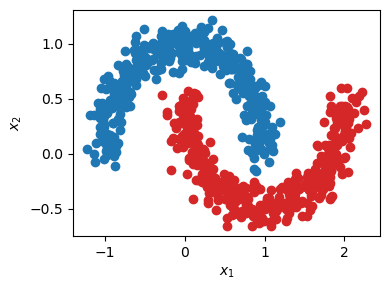

In [3]:
X_numpy, y_numpy = make_moons(n_samples=1000, noise=0.1, random_state=42)
X_train_and_val_numpy, X_test_numpy, y_train_and_val_numpy, y_test_numpy = train_test_split(X_numpy, y_numpy, test_size=1/10, random_state=42)
X_train_numpy, X_val_numpy, y_train_numpy, y_val_numpy = train_test_split(X_train_and_val_numpy, y_train_and_val_numpy, test_size=1/9, random_state=42)

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_train_numpy[y_train_numpy==1][:,0], X_train_numpy[y_train_numpy==1][:,1], color='#D62728')
ax.scatter(X_train_numpy[y_train_numpy==0][:,0], X_train_numpy[y_train_numpy==0][:,1], color='#1F77B4')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
fig.tight_layout()
plt.show()

In [4]:
X_train, y_train = torch.tensor(X_train_numpy, dtype=torch.float32), torch.tensor(y_train_numpy, dtype=torch.float32).view(-1, 1)
X_val, y_val = torch.tensor(X_val_numpy, dtype=torch.float32), torch.tensor(y_val_numpy, dtype=torch.float32).view(-1, 1)
X_test, y_test = torch.tensor(X_test_numpy, dtype=torch.float32), torch.tensor(y_test_numpy, dtype=torch.float32).view(-1, 1)

In [5]:
lr, weight_decay = 1e-2, 1e-6
model = layers.RandomFeatureGaussianProcess(in_features=2, out_features=1)
criterion = losses.ERMLoss(criterion=torch.nn.BCEWithLogitsLoss())
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [6]:
train_losses = []
for epoch in tqdm.tqdm(range(10_000)):
    model.zero_grad()
    params = torch.nn.utils.parameters_to_vector(model.parameters())
    logits = model(X_train)
    losses_dict = criterion(y_train, logits, params, len(X_train))
    losses_dict['loss'].backward()
    optimizer.step()
    train_losses.append(losses_dict['loss'].item())

100%|██████████| 10000/10000 [02:36<00:00, 63.74it/s]


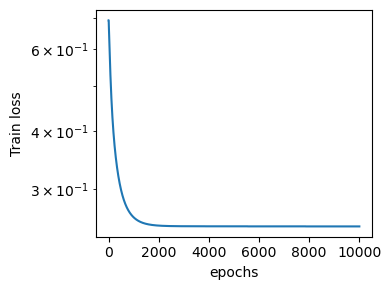

In [7]:
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.plot(range(len(train_losses)), train_losses)
ax.set_yscale('log')
ax.set_xlabel('epochs')
ax.set_ylabel('Train loss')
fig.tight_layout()
plt.show()

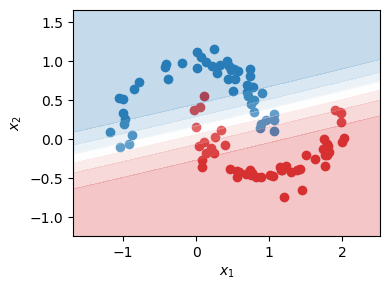

In [8]:
model.eval()
with torch.no_grad():
    xx, yy = np.meshgrid(np.arange(np.min(X_test_numpy[:,0])-0.5, np.max(X_test_numpy[:,0])+0.5, 0.01), 
                         np.arange(np.min(X_test_numpy[:,1])-0.5, np.max(X_test_numpy[:,1])+0.5, 0.01))
    Z = torch.nn.functional.sigmoid(model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)))
    Z = Z.reshape(xx.shape)
    
colors = ['#1F77B4', '#5799C7', '#8FBBDA', '#C7DDED', '#FFFFFF', '#F5C9CA', '#EB9394', '#E15D5E', '#D62728']
cmap = LinearSegmentedColormap.from_list('bwr', colors)

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_test_numpy[y_test_numpy==1][:,0], X_test_numpy[y_test_numpy==1][:,1], color='#D62728')
ax.scatter(X_test_numpy[y_test_numpy==0][:,0], X_test_numpy[y_test_numpy==0][:,1], color='#1F77B4')
ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
fig.tight_layout()
plt.show()

In [9]:
def flatten_params(model, excluded_params=['lengthscale', 'outputscale', 'sigma_param']):
    return torch.cat([param.view(-1) for name, param in model.named_parameters() if name not in excluded_params])

In [10]:
lr = 1e-2
model = layers.RandomFeatureGaussianProcess(in_features=2, out_features=1)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
setattr(model, 'linear', layers.VariationalLinear(model.linear, model.sigma_param))

model.lengthscale = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(math.sqrt(20)))))
torch.nn.utils.parametrize.register_parametrization(model, 'lengthscale', torch.nn.Softplus())
model.outputscale = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1.0))))
torch.nn.utils.parametrize.register_parametrization(model, 'outputscale', torch.nn.Softplus())

d = len(flatten_params(model))
criterion = losses.DataEmphasizedELBo(d/len(X_train), model.sigma_param, criterion=torch.nn.BCEWithLogitsLoss())
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
train_losses = []
for epoch in tqdm.tqdm(range(10_000)):
    model.zero_grad()
    params = flatten_params(model)
    logits = model(X_train)
    losses_dict = criterion(y_train, logits, params, len(X_train))
    losses_dict['loss'].backward()
    optimizer.step()
    train_losses.append(losses_dict['loss'].item())

100%|██████████| 10000/10000 [02:59<00:00, 55.58it/s]


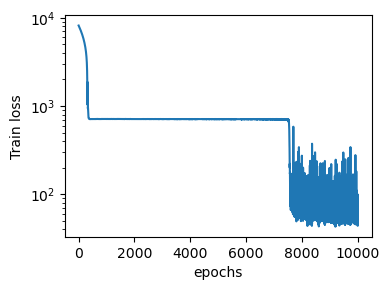

In [12]:
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.plot(range(len(train_losses)), train_losses)
ax.set_yscale('log')
ax.set_xlabel('epochs')
ax.set_ylabel('Train loss')
fig.tight_layout()
plt.show()

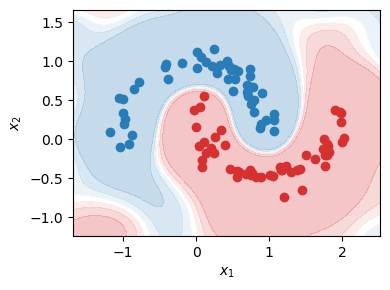

In [13]:
model.eval()
with torch.no_grad():
    xx, yy = np.meshgrid(np.arange(np.min(X_test_numpy[:,0])-0.5, np.max(X_test_numpy[:,0])+0.5, 0.01), 
                         np.arange(np.min(X_test_numpy[:,1])-0.5, np.max(X_test_numpy[:,1])+0.5, 0.01))
    Z = torch.nn.functional.sigmoid(model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)))
    Z = Z.reshape(xx.shape)

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_test_numpy[y_test_numpy==1][:,0], X_test_numpy[y_test_numpy==1][:,1], color='#D62728')
ax.scatter(X_test_numpy[y_test_numpy==0][:,0], X_test_numpy[y_test_numpy==0][:,1], color='#1F77B4')
ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
fig.tight_layout()
plt.show()